# Investigation on Traffic Crashes in Chicago


# Table of Contents
1. [Abstract](#abstract)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Modeling](#modeling)
4. [Conclusion](#conclusion)

<a id='abstract'></a>
# I. Abstract

Traffic crash is not only an major topic in Geographic AI, but also directly ralated to people's daily life. Nearly 1.3 million people die internationally every year from car accidents and in addition up to 50 million people are injured. Machine learning can be a helpful tool to analyze and reduce the risk of crashes. In this work, an data analysis is demonstrated on Chicago traffic crashes (20016-2018), followed by a prediction of risk and severity of crashes based on random forrest model. This work is a promising application for safe route planning, emergency vehicle allocation, roadway design and where to place additional traffic control devices.

<a id='exploratory-data-analysis'></a>
# II. Exploratory Data Analysis

## Data Source
Traffic crash data can be obtained at [Chicago Data Portal](https://data.cityofchicago.org/), using SODA API or exporting directly from the website. The links and descriptions of datasets are listed below:
1. [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if): Major dataset for this project.
2. [Traffic Crashes - Vehicles](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3): Information of related vehicles.
3. [Traffic Crashes - People](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d):Information of related people.
4. [Chicago Traffic Tracker - Congestion Estimates by Segments](https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Se/n4j6-wkkf): Geo information of traffic segments of Chicago arterial streets (nonfreeway streets).
5. [Chicago Traffic Tracker - Congestion Estimates by Regions](https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Re/t2qc-9pjd): Geo information of Chicago Regions.



## Data Processing

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns


Importing dataset [Traffic Crashes - Crashes](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) using SODA API.

In [33]:
from sodapy import Socrata

end_point = 'data.cityofchicago.org'
app_token = 'IaMIsAtmEfVIRb6i2lfqYvVmz'
max_rows = 300000

client = Socrata(end_point, app_token)
results = client.get("85ca-t3if", limit=max_rows)
results_df = pd.DataFrame(results)


Setting data types and have a glance.

In [34]:

cols_float = ['posted_speed_limit', 'lane_cnt', 'street_no', 'beat_of_occurrence', 'num_units', 
              'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 
              'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown', 
              'crash_hour', 'crash_day_of_week', 'crash_month',
              'latitude', 'longitude'
             ]


for col in cols_float:
    results_df[col] = results_df[col].astype(float)

results_df['crash_date'] = pd.to_datetime(results_df['crash_date'])
results_df['date_police_notified'] = pd.to_datetime(results_df['date_police_notified'])
results_df.columns = map(str.upper, results_df.columns)

In [35]:
results_df.head()

,ALIGNMENT,BEAT_OF_OCCURRENCE,CRASH_DATE,CRASH_DATE_EST_I,CRASH_DAY_OF_WEEK,CRASH_HOUR,CRASH_MONTH,CRASH_TYPE,DAMAGE,DATE_POLICE_NOTIFIED,...,STATEMENTS_TAKEN_I,STREET_DIRECTION,STREET_NAME,STREET_NO,TRAFFIC_CONTROL_DEVICE,TRAFFICWAY_TYPE,WEATHER_CONDITION,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I
0,STRAIGHT AND LEVEL,621.0,2019-05-09 00:15:00,NaN,5.0,0.0,5.0,NO INJURY / DRIVE AWAY,"OVER $1,500",2019-05-09 00:30:00,...,NaN,S,PEORIA ST,7600.0,STOP SIGN/FLASHER,NOT DIVIDED,RAIN,NaN,NaN,NaN
1,STRAIGHT AND LEVEL,1622.0,2019-05-08 23:56:00,NaN,4.0,23.0,5.0,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2019-05-09 00:02:00,...,NaN,W,BRYN MAWR AVE,6229.0,YIELD,Y-INTERSECTION,RAIN,NaN,NaN,NaN
2,STRAIGHT AND LEVEL,221.0,2019-05-08 23:39:00,NaN,4.0,23.0,5.0,NO INJURY / DRIVE AWAY,$500 OR LESS,2019-05-08 23:39:00,...,NaN,E,47TH ST,804.0,TRAFFIC SIGNAL,DIVIDED - W/MEDIAN (NOT RAISED),RAIN,NaN,NaN,NaN
3,STRAIGHT AND LEVEL,123.0,2019-05-08 22:40:00,NaN,4.0,22.0,5.0,NO INJURY / DRIVE AWAY,"OVER $1,500",2019-05-08 23:50:00,...,NaN,S,STATE ST,1100.0,TRAFFIC SIGNAL,NOT DIVIDED,RAIN,NaN,NaN,NaN
4,STRAIGHT AND LEVEL,2513.0,2019-05-08 22:30:00,NaN,4.0,22.0,5.0,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",2019-05-08 23:00:00,...,NaN,N,HARLEM AVE,1799.0,TRAFFIC SIGNAL,NOT DIVIDED,CLEAR,NaN,NaN,NaN


Select crashes in 2016-2018

In [6]:
crash = results_df[(results_df['CRASH_DATE'] < pd.datetime(2019,1,1)) & (results_df['CRASH_DATE'] >= pd.datetime(2016,1,1))].copy()

Deal with outliers and missing values in geo coordinates(LATITUDE, LONGITUDE), INJURIES_FATAL and POSTED_SPEED_LIMIT, then convert dataframe to geo dataframe.

In [7]:
crash = crash[crash['LOCATION'].notnull()]
#crash.boxplot(column=['LONGITUDE', 'LATITUDE'])
# drop rows with outliers in LATITUDE and LONGITUDE (outlier defiend as being out of 10 std range)
crash = crash[np.abs(crash['LATITUDE'] - crash['LATITUDE'].mean()) <= (10 * crash['LATITUDE'].std())]
crash = crash[np.abs(crash['LONGITUDE'] - crash['LONGITUDE'].mean()) <= (10 * crash['LONGITUDE'].std())]

crash = crash[crash['INJURIES_FATAL'].notnull()]
crash = crash[crash['MOST_SEVERE_INJURY'].notnull()]

crash = crash[(crash['POSTED_SPEED_LIMIT'] > 0) & (crash['POSTED_SPEED_LIMIT'] % 5 == 0) ]
# convert datagframe to geo-dataframe
crash['LOCATION'] = crash['LOCATION'].apply(lambda x: Point(tuple(x['coordinates'])))
#crs = {'init': 'epsg:4326'}
crash = gpd.GeoDataFrame(crash, geometry='LOCATION')

crash.shape

(239227, 48)

## Data Analysis

### An overview of geographic distribution
What does the 245k traffic crashes look like?

Text(0.5, 1.0, 'Crash in Chicago from 2016 to 2018')

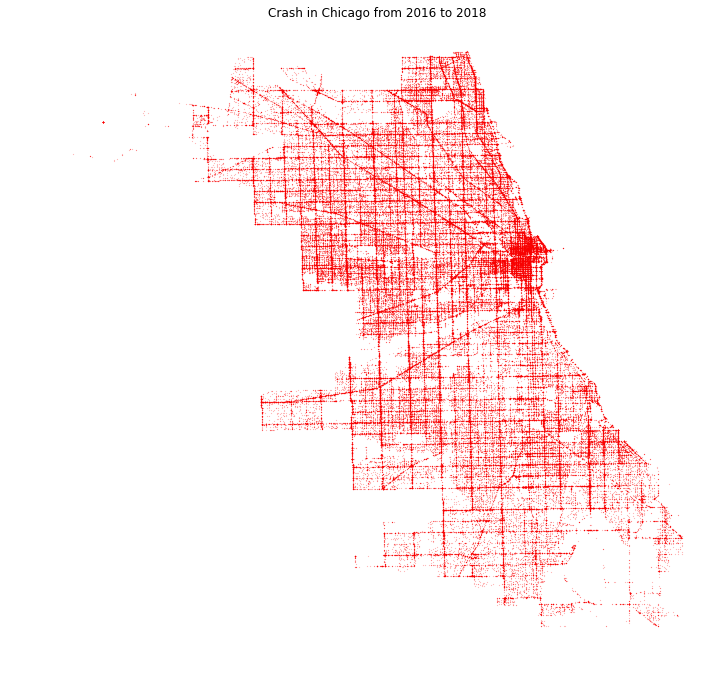

In [8]:
crash.plot(markersize=0.01, edgecolor='red',figsize=(12,12));
plt.axis('off');
plt.title('Crash in Chicago from 2016 to 2018')

In [9]:
"""crash.info()
selected_clomuns = ['RD_NO','CRASH_DATE','POSTED_SPEED_LIMIT',
                    'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION','WEATHER_CONDITION','LIGHTING_CONDITION',
                    'ROAD_DEFECT','INTERSECTION_RELATED_I',
                    'STREET_NO','STREET_DIRECTION','STREET_NAME ',
                    'LATITUDE','LONGITUDE','LOCATION ',
                    'CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH ',
                    'MOST_SEVERE_INJURY '
                   ]"""

"crash.info()\nselected_clomuns = ['RD_NO','CRASH_DATE','POSTED_SPEED_LIMIT',\n                    'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION','WEATHER_CONDITION','LIGHTING_CONDITION',\n                    'ROAD_DEFECT','INTERSECTION_RELATED_I',\n                    'STREET_NO','STREET_DIRECTION','STREET_NAME ',\n                    'LATITUDE','LONGITUDE','LOCATION ',\n                    'CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH ',\n                    'MOST_SEVERE_INJURY '\n                   ]"

### Number of crashes by a single feature

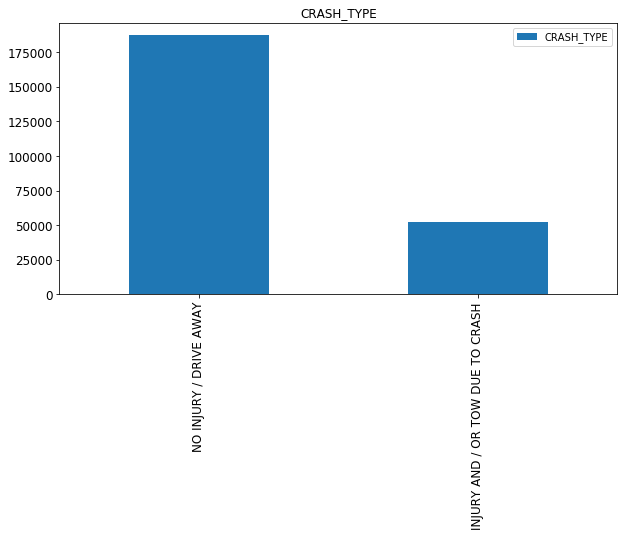

In [10]:
crash['CRASH_TYPE'].value_counts().plot(kind='bar', title ="CRASH_TYPE", figsize=(10, 5), legend=True, fontsize=12)

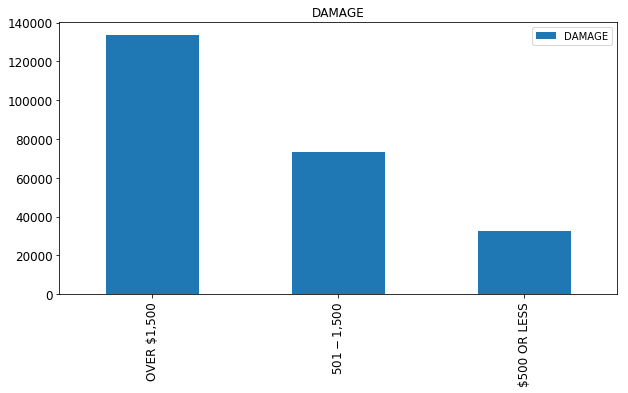

In [11]:
crash['DAMAGE'].value_counts().plot(kind='bar', title ="DAMAGE", figsize=(10, 5), legend=True, fontsize=12)

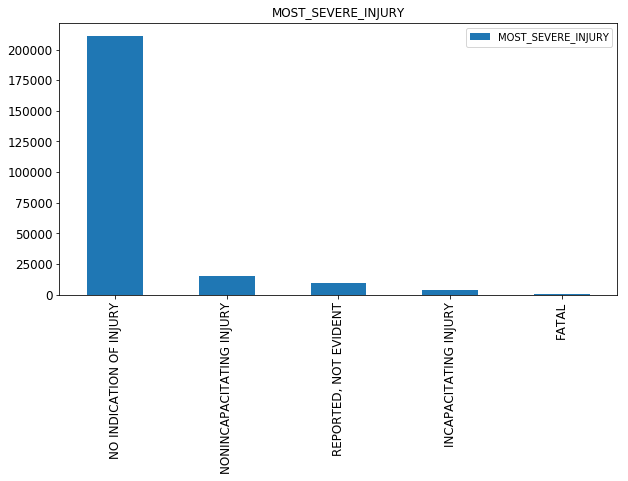

In [12]:
crash['MOST_SEVERE_INJURY'].value_counts().plot(kind='bar', title ="MOST_SEVERE_INJURY", figsize=(10, 5), legend=True, fontsize=12)

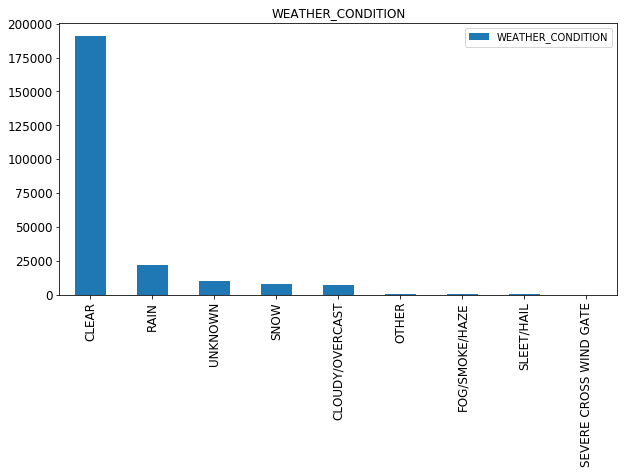

In [13]:
crash['WEATHER_CONDITION'].value_counts().plot(kind='bar', title ="WEATHER_CONDITION", figsize=(10, 5), legend=True, fontsize=12)

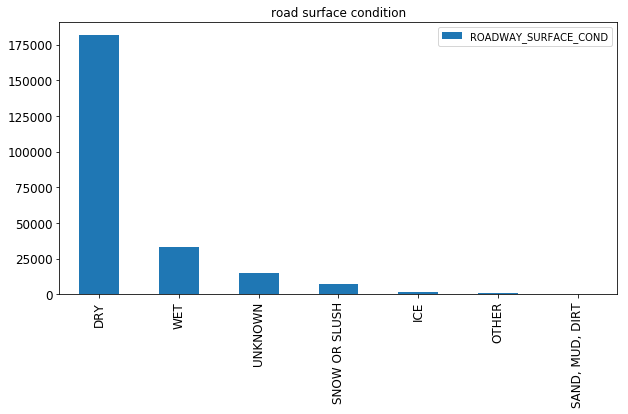

In [14]:
crash['ROADWAY_SURFACE_COND'].value_counts().plot(kind='bar', title ="road surface condition", figsize=(10, 5), legend=True, fontsize=12)

### Number of crashes by time-related varables

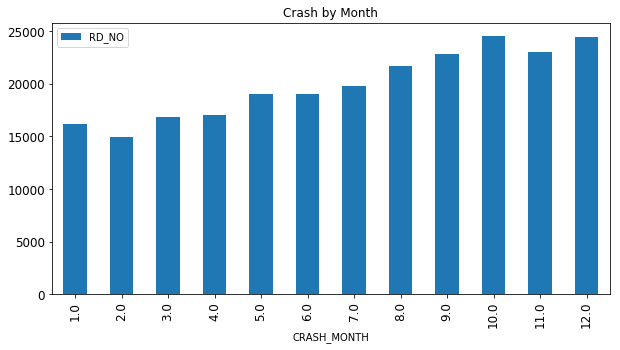

In [15]:
crash.groupby(['CRASH_MONTH']).count()['RD_NO'].plot(kind='bar', title ="Crash by Month", figsize=(10, 5), legend=True, fontsize=12)

More crashes happen in Sep to Oct, namely late autumn and early winter.

*Crashes by day of week (Sunday == 1)*

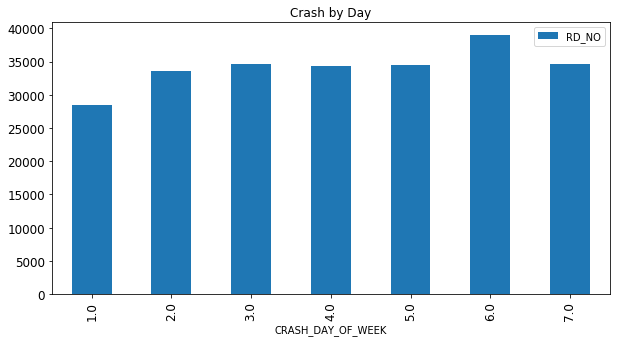

In [16]:
crash.groupby(['CRASH_DAY_OF_WEEK']).count()['RD_NO'].plot(kind='bar', title ="Crash by Day", figsize=(10, 5), legend=True, fontsize=12)

More crashes happen in Friday 

*Crashes by hours*

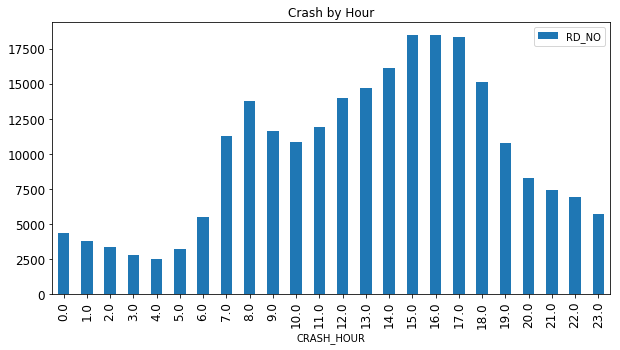

In [17]:
crash.groupby(['CRASH_HOUR']).count()['RD_NO'].plot(kind='bar', title ="Crash by Hour", figsize=(10, 5), legend=True, fontsize=12)

More crashes happen in rush hours 

<a id='folium-heatmap'></a>
### Number of crashes by location-realated variables

#### *NOTE: POSSIBILITY OF RENDERING FAILURE.*
#### The follwoing two figures are two dynamic heatmaps showing crashes distribution in 2018. In case that the figures may FAIL TO RENDER in Github repo, please visit [THIS LINK](https://nbviewer.jupyter.org/github/shengbo-ma/Prediction-of-Traffic-Crash-Risk-in-Chicago/blob/master/Chicago_Traffic_Crashes.ipynb#folium-heatmap) to see them.

*Dynamic Heapmap 1. Geographic distribution of crash by month in 2018*

In [18]:
map_chicago = folium.Map(location=[41.830994, -87.647345],
                         tiles = "Stamen Terrain",
                         zoom_start = 10) 

crash2018 = crash[(crash['CRASH_DATE'] < pd.datetime(2019,1,1)) & (crash['CRASH_DATE'] >= pd.datetime(2018,1,1))].copy()

heatmap = []
for i in range(1, 13):
    df = crash2018[crash2018['CRASH_MONTH'] == i]
    df1 = df.sample(int(len(df)*0.3))
    cood = [[row["LATITUDE"], row["LONGITUDE"]] for idx, row in df1.iterrows()]
    heatmap.append(cood)
    
plugins.HeatMapWithTime(heatmap, radius=3, auto_play=True,max_opacity=0.8).add_to(map_chicago)
map_chicago


*Dynamic Heapmap 2. Geographic distribution of crash by hour in 2018*

In [19]:
map_chicago = folium.Map(location=[41.830994, -87.647345],
                         tiles = "Stamen Terrain",
                         zoom_start = 10) 

crash2018 = crash[(crash['CRASH_DATE'] < pd.datetime(2019,1,1)) & (crash['CRASH_DATE'] >= pd.datetime(2018,1,1))].copy()

heatmap = []
for i in range(0,24):
    df = crash2018[crash2018['CRASH_HOUR'] == i]
    df1 = df.sample(int(len(df)*0.1))
    cood = [[row["LATITUDE"], row["LONGITUDE"]] for idx, row in df1.iterrows()]
    heatmap.append(cood)
    
plugins.HeatMapWithTime(heatmap, radius=5, auto_play=True,max_opacity=0.8).add_to(map_chicago)
map_chicago

In [20]:
#map_chicago.save('crash heatmap.html')

*number of crashes by street*

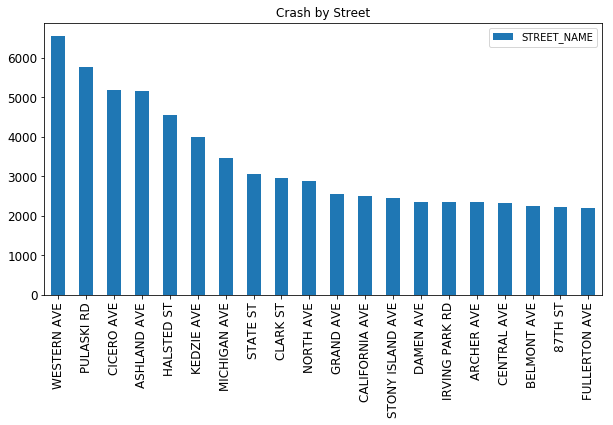

In [21]:
crash['STREET_NAME'].value_counts()[:min(20, len(crash))].plot(kind='bar', title ="Crash by Street", figsize=(10, 5), legend=True, fontsize=12)

<a id='modeling'></a>
# Modeling

In [22]:

features = ['POSTED_SPEED_LIMIT',
            'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION','WEATHER_CONDITION','LIGHTING_CONDITION',
            'ROAD_DEFECT',
            'STREET_NO','STREET_DIRECTION','STREET_NAME',
            'LATITUDE','LONGITUDE',
            'CRASH_HOUR','CRASH_DAY_OF_WEEK','CRASH_MONTH',
            'MOST_SEVERE_INJURY','DAMAGE','FIRST_CRASH_TYPE','TRAFFICWAY_TYPE',
            'INJURIES_FATAL', 'INJURIES_INCAPACITATING'
            ]


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

In [24]:
# Convert geo-dataframe into a regular dataframe.
df = pd.DataFrame(crash[features])
#df.head()
#ss_lat = StandardScaler()
#df['LATITUDE'] = ss_lat.fit_transform(df['LATITUDE'].values.reshape(-1,1)).flatten()
#ss_lon = StandardScaler()
#df['LONGITUDE'] = ss_lon.fit_transform(df['LONGITUDE'].values.reshape(-1,1)).flatten()

#df.shape
df.describe()


,POSTED_SPEED_LIMIT,STREET_NO,LATITUDE,LONGITUDE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,INJURIES_FATAL,INJURIES_INCAPACITATING
count,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000,239227.000000
mean,28.790876,3575.523670,41.861295,-87.677798,13.213233,4.121926,7.035310,0.000915,0.017402
std,5.369394,2802.665901,0.084772,0.057604,5.434908,1.965087,3.411727,0.033144,0.154232
min,5.000000,1.000000,41.644670,-87.925036,0.000000,1.000000,1.000000,0.000000,0.000000
25%,30.000000,1199.000000,41.787749,-87.720186,9.000000,2.000000,4.000000,0.000000,0.000000
50%,30.000000,3100.000000,41.878310,-87.672286,14.000000,4.000000,7.000000,0.000000,0.000000
75%,30.000000,5500.000000,41.924977,-87.632788,17.000000,6.000000,10.000000,0.000000,0.000000
max,70.000000,13799.000000,42.022780,-87.524589,23.000000,7.000000,12.000000,3.000000,7.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239227 entries, 38726 to 285196
Data columns (total 20 columns):
POSTED_SPEED_LIMIT         239227 non-null float64
TRAFFIC_CONTROL_DEVICE     239227 non-null object
DEVICE_CONDITION           239227 non-null object
WEATHER_CONDITION          239227 non-null object
LIGHTING_CONDITION         239227 non-null object
ROAD_DEFECT                239227 non-null object
STREET_NO                  239227 non-null float64
STREET_DIRECTION           239227 non-null object
STREET_NAME                239227 non-null object
LATITUDE                   239227 non-null float64
LONGITUDE                  239227 non-null float64
CRASH_HOUR                 239227 non-null float64
CRASH_DAY_OF_WEEK          239227 non-null float64
CRASH_MONTH                239227 non-null float64
MOST_SEVERE_INJURY         239227 non-null object
DAMAGE                     239227 non-null object
FIRST_CRASH_TYPE           239227 non-null object
TRAFFICWAY_TYPE            2

In [26]:
"""
cols = ['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROAD_DEFECT', 
       'STREET_DIRECTION', 'STREET_NAME', 
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'
       ]

for i in range(len(cols)):
    print(cols[i])
    df[cols[i]].value_counts()
"""

"\ncols = ['POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',\n       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROAD_DEFECT', \n       'STREET_DIRECTION', 'STREET_NAME', \n       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'\n       ]\n\nfor i in range(len(cols)):\n    print(cols[i])\n    df[cols[i]].value_counts()\n"

### Correlation coeeficients between features.

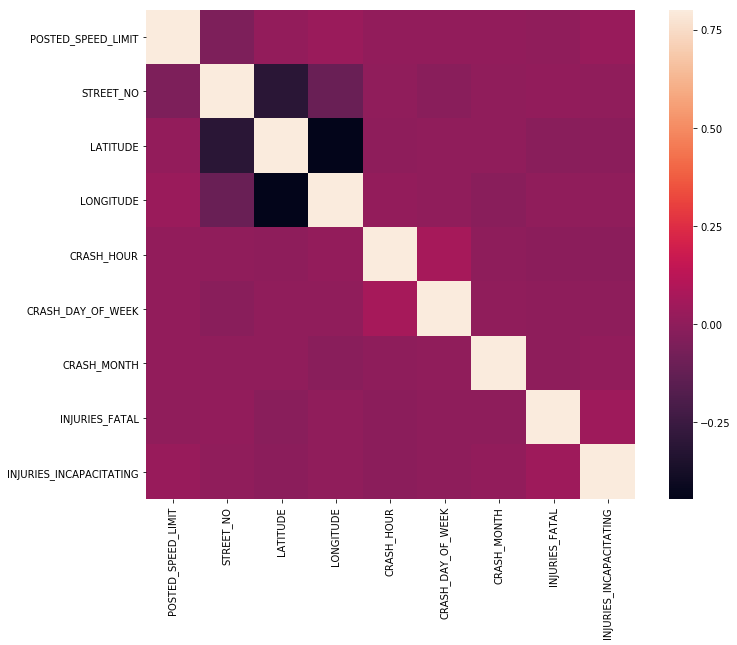

In [27]:
corr_mat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True)

### Encoding of labels

In [28]:
# Encoding catagory variables
from sklearn.preprocessing import LabelEncoder
lblE = LabelEncoder()
for i in df:
    if df[i].dtype == 'object':
        lblE.fit(df[i])
        df[i] = lblE.transform(df[i])
df = pd.get_dummies(df)
df.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,ROAD_DEFECT,STREET_NO,STREET_DIRECTION,STREET_NAME,LATITUDE,LONGITUDE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,MOST_SEVERE_INJURY,DAMAGE,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,INJURIES_FATAL,INJURIES_INCAPACITATING
38726,30.0,12,1,8,1,5,3400.0,3,841,41.884754,-87.711230,23.0,2.0,12.0,2,0,14,5,0.0,0.0
38727,30.0,2,3,0,1,1,12901.0,2,740,41.660397,-87.618035,23.0,2.0,12.0,2,1,12,5,0.0,0.0
38728,35.0,2,3,0,1,1,699.0,2,835,41.873324,-87.616936,23.0,2.0,12.0,2,0,12,2,0.0,0.0
38729,30.0,2,3,8,5,1,4641.0,2,974,41.809188,-87.666049,23.0,2.0,12.0,2,2,7,5,0.0,0.0
38730,30.0,2,3,4,1,1,530.0,1,822,41.891682,-87.632731,23.0,2.0,12.0,2,2,10,5,0.0,0.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['INJURIES_FATAL', 'INJURIES_INCAPACITATING'], axis=1), 
                                                    df['INJURIES_FATAL'], test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160282, 18), (78945, 18), (160282,), (78945,))

In [30]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), 
           m.score(X_test, y_test)]
    
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print ("\nRMSE for train set: ", res[0],
           "\nRMSE for test set: ", res[1],
           "\nScore for train set: ", res[2],
           "\nScore for test set: ", res[3]
          )

### Random Forrest Regression

In [31]:

rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(X_train, y_train)
print_score(rfr)


RMSE for train set:  0.003979270226112333 
RMSE for test set:  0.011025566360059398 
Score for train set:  0.9853183475922144 
Score for test set:  0.8932866428323727


In [32]:
f_imp = pd.DataFrame(data={'importance':rfr.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp

,importance
features,
MOST_SEVERE_INJURY,0.922133
STREET_NAME,0.012791
STREET_NO,0.012258
CRASH_HOUR,0.012220
TRAFFICWAY_TYPE,0.007203
FIRST_CRASH_TYPE,0.005789
CRASH_MONTH,0.004466
LONGITUDE,0.004257
CRASH_DAY_OF_WEEK,0.004214


Besides the non-surprising result that 'MOST_SEVERE_INJURY' is most related, we can see in the feature importance table that:
1. The street where the crash happened are more related to the number of death.
2. The hour and day of week are more related to the number of death, comparede to the month.
3. Weather and traffic control device seems not related to the number of death, which is not a straightforward result.

<a id='conclusion'></a>
# Conclusion

By analyzing the modeling the traffic crash data, we have successfully predict the severity of crashes based on Random Forrest Regression with a score of 0.89. Future works will be predicting the probobility of crashes per raod segment and per hour. 